## 1. Import Required Libraries and Setup

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import json
from pathlib import Path
from tqdm import tqdm
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
from shapely.validation import make_valid
from shapely.affinity import scale
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS

# Import custom functions
from large_scale_functions import load_inference_model, process_large_image, convert_to_polygons, assess_quality
from dask_model_loader import UNetWithHeight


## 2. Load Trained Height Model

In [2]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

# Load the best height model
model_path = 'height_analysis_output/best_height_model.pth'
model = load_inference_model(model_path, device)

print(f"Model loaded successfully from: {model_path}")
print(f"Model type: {type(model).__name__}")

🖥️  Using device: cuda
Model loaded successfully from: height_analysis_output/best_height_model.pth
Model type: UNetWithHeight
Model loaded successfully from: height_analysis_output/best_height_model.pth
Model type: UNetWithHeight


## 3. Advanced Vector Conversion Functions

In [ ]:
class VectorConverter:
    """
    Advanced vector conversion with topology correction and GIS integration
    """
    
    def __init__(self, pixel_size=0.5, crs='EPSG:4326'):
        """
        Initialize vector converter
        
        """
        self.pixel_size = pixel_size
        self.crs = crs
        
    def mask_to_polygons_advanced(self, mask, height_map=None, threshold=0.5, 
                                 min_area=50, simplify_tolerance=1.0):
        """
        Convert segmentation mask to polygons with advanced processing
        
        """
        # Convert to binary mask
        binary_mask = (mask > threshold).astype(np.uint8)
        
        # Apply morphological operations for cleanup
        kernel = np.ones((3, 3), np.uint8)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        
        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        polygons = []
        
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            
            if area >= min_area:
                # Simplify polygon
                epsilon = simplify_tolerance * cv2.arcLength(contour, True) / 100
                simplified = cv2.approxPolyDP(contour, epsilon, True)
                
                if len(simplified) >= 3:
                    # Convert to shapely polygon
                    coords = simplified.squeeze().tolist()
                    if len(coords) >= 3:
                        try:
                            # Convert pixel coordinates to real-world coordinates
                            real_coords = [(x * self.pixel_size, y * self.pixel_size) for x, y in coords]
                            poly = Polygon(real_coords)
                            
                            # Validate and fix topology
                            if not poly.is_valid:
                                poly = make_valid(poly)
                            
                            if poly.is_valid and not poly.is_empty:
                                # Calculate properties
                                properties = {
                                    'building_id': f'building_{i:04d}',
                                    'area_m2': float(poly.area),
                                    'perimeter_m': float(poly.length),
                                    'confidence': float(np.mean(mask[binary_mask == 1]))
                                }
                                
                                # Add height information if available
                                if height_map is not None:
                                    # Get height statistics for this polygon
                                    mask_poly = np.zeros_like(binary_mask)
                                    cv2.fillPoly(mask_poly, [simplified], 1)
                                    height_values = height_map[mask_poly == 1]
                                    
                                    if len(height_values) > 0:
                                        properties.update({
                                            'height_mean': float(np.mean(height_values)),
                                            'height_max': float(np.max(height_values)),
                                            'height_std': float(np.std(height_values))
                                        })
                                
                                polygons.append({
                                    'geometry': poly,
                                    'properties': properties
                                })
                                
                        except Exception as e:
                            print(f"⚠️  Error processing polygon {i}: {e}")
                            continue
        
        return polygons
    
    def topology_correction(self, polygons, buffer_distance=0.1):
        """
        Apply topology correction to polygons
       
        """
        corrected_polygons = []
        
        for poly_dict in polygons:
            try:
                poly = poly_dict['geometry']
                
                # Apply small buffer to fix topology issues
                buffered = poly.buffer(buffer_distance).buffer(-buffer_distance)
                
                if buffered.is_valid and not buffered.is_empty:
                    # Handle multipolygon results
                    if buffered.geom_type == 'MultiPolygon':
                        # Take the largest polygon
                        largest_poly = max(buffered.geoms, key=lambda x: x.area)
                        if largest_poly.area > 10:  # Minimum area threshold
                            poly_dict['geometry'] = largest_poly
                            corrected_polygons.append(poly_dict)
                    else:
                        poly_dict['geometry'] = buffered
                        corrected_polygons.append(poly_dict)
                        
            except Exception as e:
                print(f"⚠️  Error in topology correction: {e}")
                continue
        
        return corrected_polygons
    
    def create_geodataframe(self, polygons):
        """
        Create GeoDataFrame from polygons
        
        """
        if not polygons:
            return gpd.GeoDataFrame()
        
        # Extract geometries and properties
        geometries = [p['geometry'] for p in polygons]
        properties = [p['properties'] for p in polygons]
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame(properties, geometry=geometries, crs=self.crs)
        
        # Add additional calculated fields
        gdf['shape_length'] = gdf.geometry.length
        gdf['shape_area'] = gdf.geometry.area
        gdf['compactness'] = (4 * np.pi * gdf['shape_area']) / (gdf['shape_length'] ** 2)
        
        return gdf
    
    def export_vectors(self, gdf, output_dir, base_name="building_footprints"):
        """
        Export vector data to multiple formats
        
        """
        if gdf.empty:
            print("⚠️  No data to export")
            return
        
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True, parents=True)
        
        # Export to GeoJSON
        geojson_path = output_path / f"{base_name}.geojson"
        gdf.to_file(geojson_path, driver='GeoJSON')
        
        # Export to Shapefile
        shapefile_path = output_path / f"{base_name}.shp"
        gdf.to_file(shapefile_path, driver='ESRI Shapefile')
        
        # Export to GeoPackage
        gpkg_path = output_path / f"{base_name}.gpkg"
        gdf.to_file(gpkg_path, driver='GPKG')
        
        print(f"✅ Vector data exported to:")
        print(f"   📄 GeoJSON: {geojson_path}")
        print(f"   📄 Shapefile: {shapefile_path}")
        print(f"   📄 GeoPackage: {gpkg_path}")
        
        return {
            'geojson': geojson_path,
            'shapefile': shapefile_path,
            'geopackage': gpkg_path
        }

# Initialize converter
converter = VectorConverter(pixel_size=0.5, crs='EPSG:4326')
print("VectorConverter initialized successfully!")

VectorConverter initialized successfully!


## 4. Process Sample Data from Preprocessed Patches

In [4]:
# Load processed height model outputs from height analysis
outputs_dir = Path('height_analysis_output/vector_map_exports')

# Find all available patches from height model outputs
segmentation_files = list(outputs_dir.glob('*_segmentation.png'))
height_files = list(outputs_dir.glob('*_height.png'))
metadata_files = list(outputs_dir.glob('*_metadata.json'))

# Extract patch numbers
patch_numbers = []
for seg_file in segmentation_files:
    patch_name = seg_file.stem.replace('_segmentation', '')
    patch_numbers.append(patch_name)

patch_numbers = sorted(patch_numbers)
print(f"Found {len(patch_numbers)} processed patches from height model")
print(f"Height model outputs directory: {outputs_dir}")
print(f"Patch range: {patch_numbers[0]} to {patch_numbers[-1]}")

# Show first few patches
print(f"Sample patches: {patch_numbers[:5]}...")

# Select a patch for processing  
selected_patch = patch_numbers[100]  # Select patch from middle of range
print(f"\nProcessing patch: {selected_patch}")

# Define file paths for selected patch
seg_path = outputs_dir / f"{selected_patch}_segmentation.png"
height_path = outputs_dir / f"{selected_patch}_height.png"
metadata_path = outputs_dir / f"{selected_patch}_metadata.json"

print(f"Segmentation: {seg_path.name}")
print(f"Height map: {height_path.name}")
print(f"Metadata: {metadata_path.name}")

# Load metadata
if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        patch_metadata = json.load(f)
    print(f"\nPatch metadata:")
    for key, value in patch_metadata.items():
        print(f"   {key}: {value}")
else:
    print(f"Metadata file not found: {metadata_path}")
    patch_metadata = {}

Found 18100 processed patches from height model
Height model outputs directory: height_analysis_output\vector_map_exports
Patch range: patch_0000 to patch_17999
Sample patches: ['patch_0000', 'patch_00000', 'patch_00001', 'patch_00002', 'patch_00003']...

Processing patch: patch_00090
Segmentation: patch_00090_segmentation.png
Height map: patch_00090_height.png
Metadata: patch_00090_metadata.json

Patch metadata:
   patch_name: patch_00090
   patch_index: 90
   original_size: [256, 256]
   segmentation_threshold: 0.5
   height_scale_factor: 50.0
   max_predicted_height: 14.792236328125
   mean_predicted_height: 12.505590438842773
   building_pixel_count: 12393
   total_pixel_count: 65536


## 5. Process Images and Generate Vectors

Processing height model outputs for patch: patch_00090
Segmentation shape: (256, 256)
Segmentation range: 0.000 - 1.000
Height map shape: (256, 256)
Height range: 5.294 - 7.255
Scale factor applied: 50.0


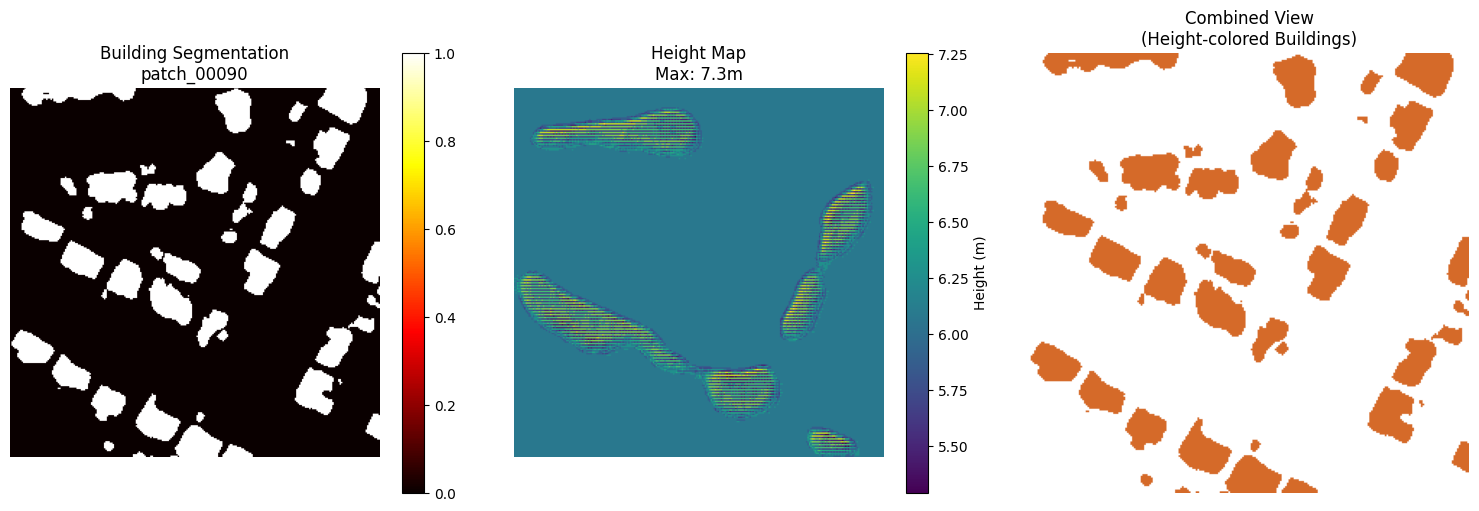

Successfully loaded height model outputs
Building pixels: 12393
Coverage: 18.9%


In [5]:
# Process the selected height model outputs
if seg_path.exists() and height_path.exists():
    print(f"Processing height model outputs for patch: {selected_patch}")
    
    # Load segmentation mask
    segmentation_img = cv2.imread(str(seg_path), cv2.IMREAD_GRAYSCALE)
    if segmentation_img is None:
        print(f"Could not load segmentation: {seg_path}")
        segmentation = None
    else:
        # Convert to float and normalize
        segmentation = segmentation_img.astype(np.float32) / 255.0
        print(f"Segmentation shape: {segmentation.shape}")
        print(f"Segmentation range: {segmentation.min():.3f} - {segmentation.max():.3f}")
    
    # Load height map
    height_img = cv2.imread(str(height_path), cv2.IMREAD_GRAYSCALE)
    if height_img is None:
        print(f"Could not load height map: {height_path}")
        height_map = None
    else:
        # Convert to float and apply scale factor from metadata
        height_scale = patch_metadata.get('height_scale_factor', 50.0)
        height_map = height_img.astype(np.float32) * height_scale / 255.0
        print(f"Height map shape: {height_map.shape}")
        print(f"Height range: {height_map.min():.3f} - {height_map.max():.3f}")
        print(f"Scale factor applied: {height_scale}")
    
    if segmentation is not None:
        # Display the loaded data
        plt.figure(figsize=(15, 5))
        
        # Plot segmentation
        plt.subplot(1, 3, 1)
        plt.imshow(segmentation, cmap='hot')
        plt.title(f'Building Segmentation\n{selected_patch}')
        plt.colorbar()
        plt.axis('off')
        
        # Plot height map
        if height_map is not None:
            plt.subplot(1, 3, 2)
            plt.imshow(height_map, cmap='viridis')
            plt.title(f'Height Map\nMax: {height_map.max():.1f}m')
            plt.colorbar(label='Height (m)')
            plt.axis('off')
            
            # Plot overlay - segmentation with height
            plt.subplot(1, 3, 3)
            # Create RGBA overlay
            overlay = np.zeros((*segmentation.shape, 4))
            # Use segmentation as alpha channel
            overlay[:, :, 3] = segmentation
            # Use height map for color
            if height_map.max() > 0:
                normalized_height = height_map / height_map.max()
                overlay[:, :, 0] = normalized_height  # Red channel
                overlay[:, :, 1] = normalized_height * 0.5  # Green channel  
                overlay[:, :, 2] = 1 - normalized_height  # Blue channel
            
            plt.imshow(overlay)
            plt.title('Combined View\n(Height-colored Buildings)')
            plt.axis('off')
        else:
            plt.subplot(1, 3, 2)
            plt.text(0.5, 0.5, 'Height Map\nNot Available', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.text(0.5, 0.5, 'Combined View\nNot Available', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Successfully loaded height model outputs")
        print(f"Building pixels: {patch_metadata.get('building_pixel_count', 'Unknown')}")
        print(f"Coverage: {(patch_metadata.get('building_pixel_count', 0) / patch_metadata.get('total_pixel_count', 1) * 100):.1f}%")
        
    else:
        print("Failed to load segmentation data")

else:
    print(f"Required files not found:")
    print(f"   Segmentation: {seg_path.exists()}")
    print(f"   Height: {height_path.exists()}")
    segmentation = None
    height_map = None

## 6. Convert to Vector Polygons

In [6]:
if segmentation is not None:
    print("🔄 Converting segmentation to vector polygons...")
    
    # Convert mask to polygons
    polygons = converter.mask_to_polygons_advanced(
        mask=segmentation,
        height_map=height_map,
        threshold=0.5,
        min_area=50,
        simplify_tolerance=1.0
    )
    
    print(f"Generated {len(polygons)} initial polygons")
    
    if polygons:
        # Apply topology correction
        print("Applying topology correction...")
        corrected_polygons = converter.topology_correction(polygons)
        
        print(f"{len(corrected_polygons)} polygons after topology correction")
        
        # Create GeoDataFrame
        print("Creating GeoDataFrame...")
        gdf = converter.create_geodataframe(corrected_polygons)
        
        if not gdf.empty:
            print(f"GeoDataFrame created with {len(gdf)} features")
            
            # Display statistics
            print("\nBuilding Statistics:")
            print(f"   Total buildings: {len(gdf)}")
            print(f"   Total area: {gdf['area_m2'].sum():.2f} m²")
            print(f"   Average area: {gdf['area_m2'].mean():.2f} m²")
            print(f"   Area range: {gdf['area_m2'].min():.2f} - {gdf['area_m2'].max():.2f} m²")
            
            if 'height_mean' in gdf.columns:
                print(f"   Average height: {gdf['height_mean'].mean():.2f}")
                print(f"   Height range: {gdf['height_mean'].min():.2f} - {gdf['height_mean'].max():.2f}")
            
            # Show first few rows
            print("\nSample data:")
            display(gdf.head())
            
        else:
            print("GeoDataFrame is empty")
    else:
        print("No polygons generated")
        gdf = None
else:
    print("No segmentation data available")
    gdf = None

🔄 Converting segmentation to vector polygons...
Generated 32 initial polygons
Applying topology correction...
32 polygons after topology correction
Creating GeoDataFrame...
GeoDataFrame created with 32 features

Building Statistics:
   Total buildings: 32
   Total area: 2739.75 m²
   Average area: 85.62 m²
   Area range: 14.38 - 146.25 m²
   Average height: 6.08
   Height range: 6.08 - 6.08

Sample data:


,building_id,area_m2,perimeter_m,confidence,height_mean,height_max,height_std,geometry,shape_length,shape_area,compactness
0,building_0001,23.500,23.410663,0.992309,6.078431,6.078432,9.536743e-07,"POLYGON ((73.50011 127.49989, 73.50245 127.5, ...",23.408869,23.500044,0.538912
1,building_0003,117.625,43.567843,0.992309,6.078431,6.078432,9.536743e-07,"POLYGON ((57.50011 127.49989, 57.50245 127.5, ...",43.566732,117.625014,0.778753
2,building_0004,26.000,21.944272,0.992309,6.078431,6.078432,9.536743e-07,"POLYGON ((123.50011 117.00003, 123.5 117.00232...",21.943364,25.999999,0.678542
3,building_0006,122.500,47.061847,0.992309,6.078431,6.078432,4.768372e-07,"POLYGON ((43.50012 116.99996, 43.50186 117.001...",47.054676,122.500315,0.695251
4,building_0007,86.375,37.344463,0.992309,6.078431,6.078432,4.768372e-07,"POLYGON ((28.50011 107.50003, 28.5 107.50233, ...",37.328905,86.375734,0.778953


## 7. Visualize Vector Results

Visualizing vector results...


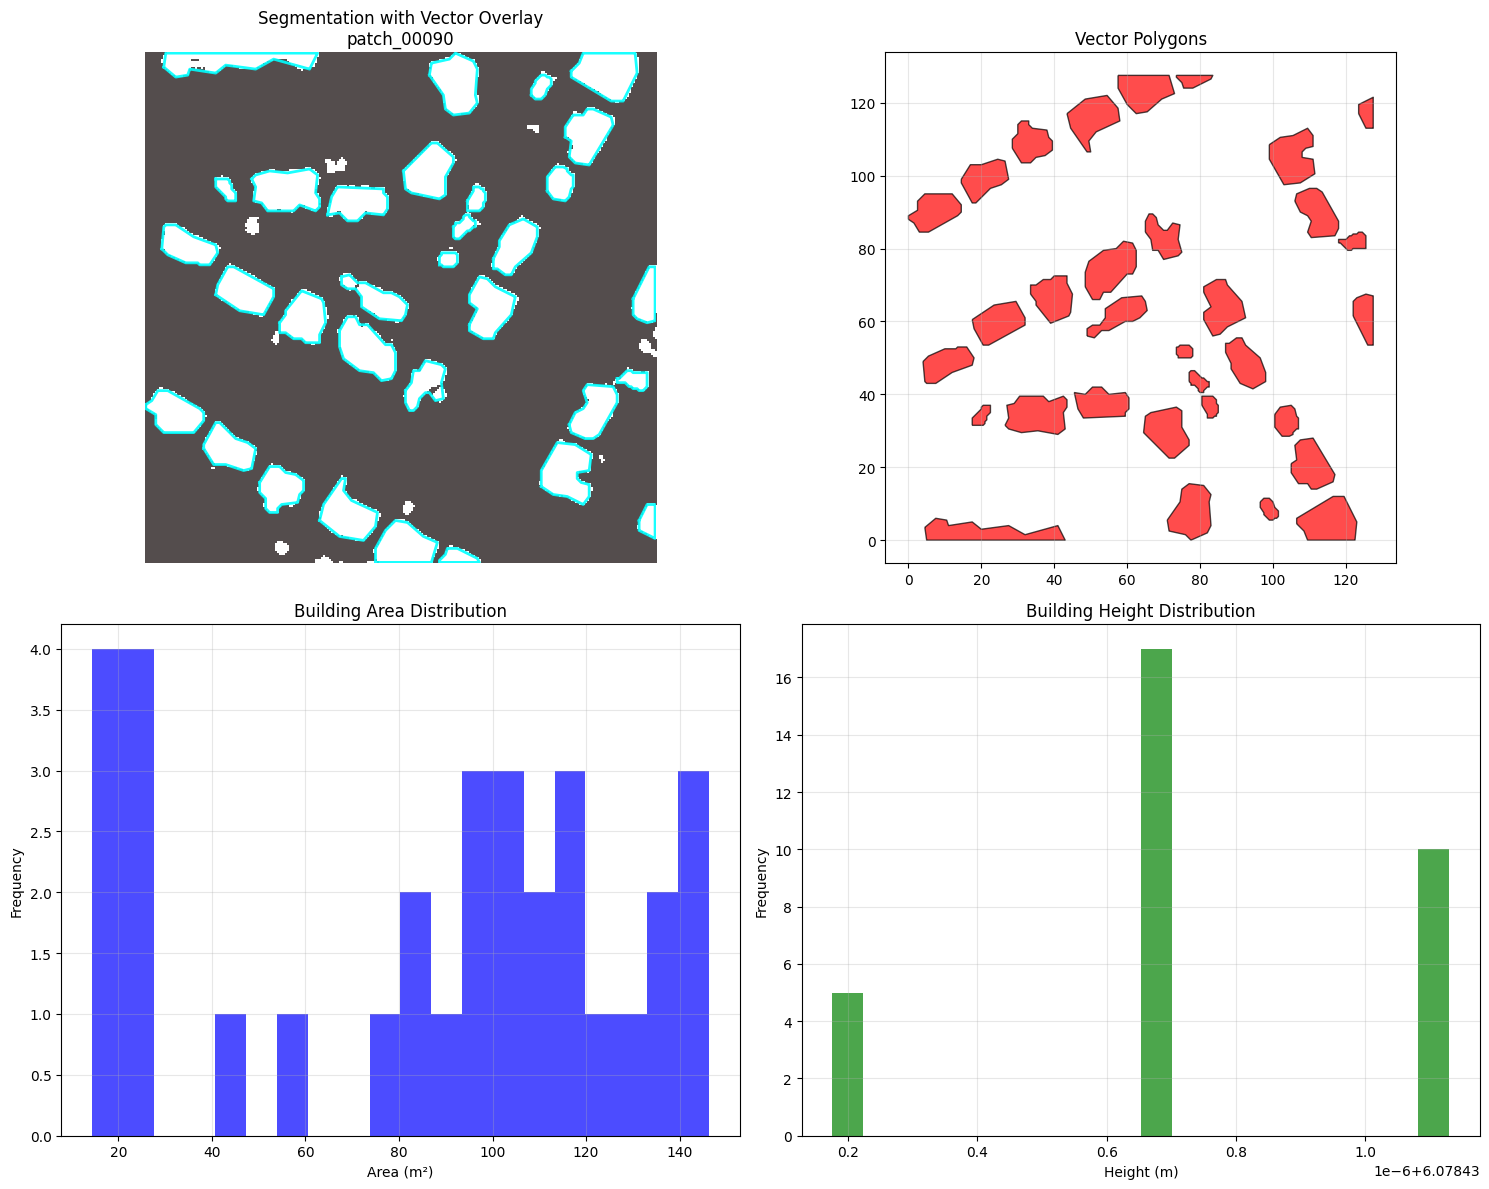

Visualization completed
Creating detailed height visualization...


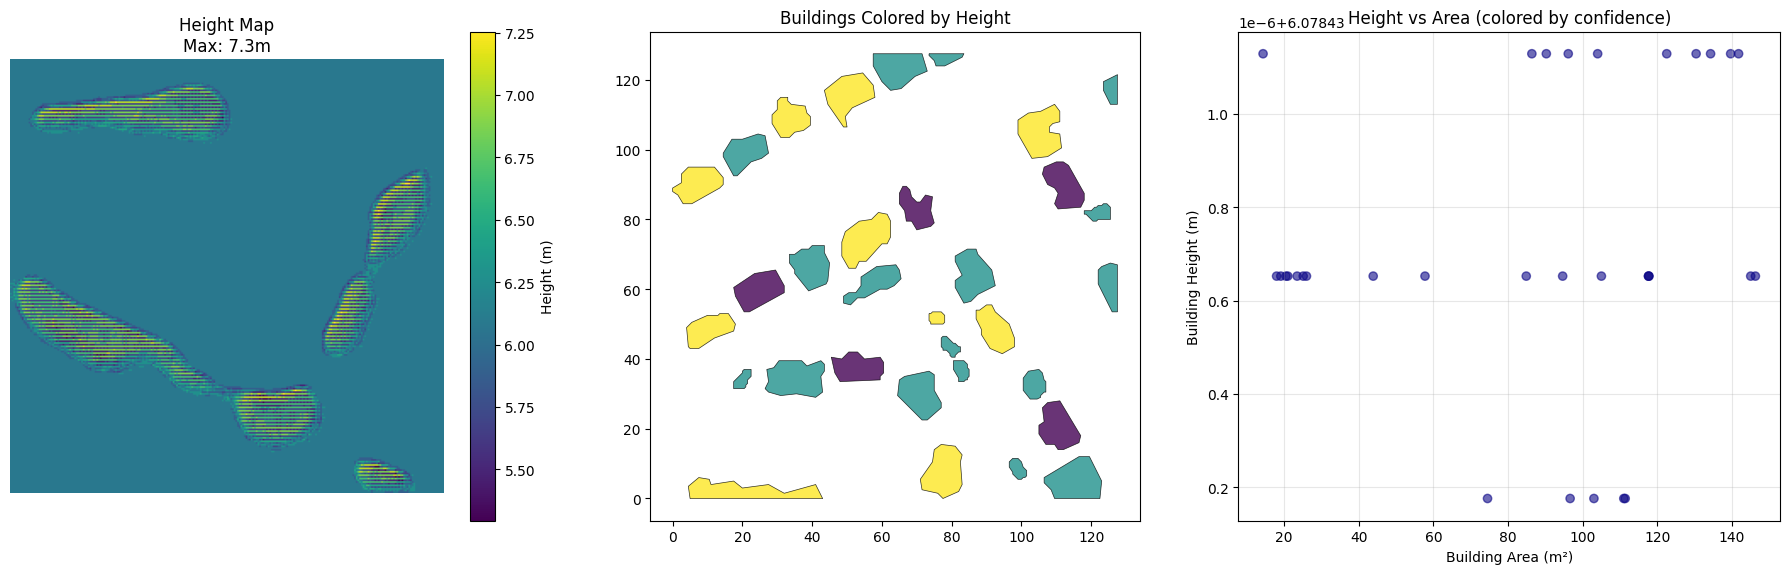

Detailed height visualization completed


In [7]:
if gdf is not None and not gdf.empty:
    print("Visualizing vector results...")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Segmentation with overlaid vectors
    if segmentation is not None:
        axes[0, 0].imshow(segmentation, cmap='hot', alpha=0.7)
        for poly_dict in corrected_polygons:
            x, y = poly_dict['geometry'].exterior.xy
            # Convert back to pixel coordinates for overlay
            x_pix = [coord / converter.pixel_size for coord in x]
            y_pix = [coord / converter.pixel_size for coord in y]
            axes[0, 0].plot(x_pix, y_pix, 'cyan', linewidth=2, alpha=0.9)
        axes[0, 0].set_title(f'Segmentation with Vector Overlay\n{selected_patch}')
        axes[0, 0].axis('off')
    else:
        axes[0, 0].text(0.5, 0.5, 'No Segmentation\nData Available', 
                       ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Segmentation with Vectors')
    
    # Plot 2: Vector polygons only
    gdf.plot(ax=axes[0, 1], color='red', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Vector Polygons')
    axes[0, 1].set_aspect('equal')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Area distribution
    axes[1, 0].hist(gdf['area_m2'], bins=20, alpha=0.7, color='blue')
    axes[1, 0].set_xlabel('Area (m²)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Building Area Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Height distribution (if available)
    if 'height_mean' in gdf.columns:
        axes[1, 1].hist(gdf['height_mean'], bins=20, alpha=0.7, color='green')
        axes[1, 1].set_xlabel('Height (m)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Building Height Distribution')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Height Data\nAvailable', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Height Distribution')
    
    plt.tight_layout()
    plt.show()
    
    print("Visualization completed")
    
    # Additional detailed plot if height data is available
    if height_map is not None and 'height_mean' in gdf.columns:
        print("Creating detailed height visualization...")
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot height map
        im1 = axes[0].imshow(height_map, cmap='viridis')
        axes[0].set_title(f'Height Map\nMax: {height_map.max():.1f}m')
        axes[0].axis('off')
        plt.colorbar(im1, ax=axes[0], label='Height (m)')
        
        # Plot buildings colored by height
        gdf.plot(ax=axes[1], column='height_mean', cmap='viridis', 
                alpha=0.8, edgecolor='black', linewidth=0.5)
        axes[1].set_title('Buildings Colored by Height')
        axes[1].set_aspect('equal')
        
        # Create height vs area scatter plot
        axes[2].scatter(gdf['area_m2'], gdf['height_mean'], 
                       alpha=0.6, c=gdf['confidence'], cmap='plasma')
        axes[2].set_xlabel('Building Area (m²)')
        axes[2].set_ylabel('Building Height (m)')
        axes[2].set_title('Height vs Area (colored by confidence)')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("Detailed height visualization completed")
    
else:
    print("No vector data available for visualization")

## 8. Export Vector Data

In [8]:
if gdf is not None and not gdf.empty:
    print("Exporting vector data...")
    
    # Create output directory based on selected patch
    output_dir = f'height_analysis_output/vector_map_exports/{selected_patch}_vectors'
    
    # Export to multiple formats
    export_paths = converter.export_vectors(
        gdf=gdf,
        output_dir=output_dir,
        base_name=f'{selected_patch}_buildings'
    )
    
    # Save comprehensive processing metadata
    metadata = {
        'processing_date': str(pd.Timestamp.now()),
        'source_patch': selected_patch,
        'source_segmentation': str(seg_path),
        'source_height_map': str(height_path),
        'original_metadata': patch_metadata,
        'vector_processing': {
            'total_buildings': len(gdf),
            'total_area_m2': float(gdf['area_m2'].sum()),
            'average_area_m2': float(gdf['area_m2'].mean()),
            'median_area_m2': float(gdf['area_m2'].median()),
            'min_area_m2': float(gdf['area_m2'].min()),
            'max_area_m2': float(gdf['area_m2'].max()),
            'pixel_size_m': converter.pixel_size,
            'coordinate_system': converter.crs,
            'has_height_data': 'height_mean' in gdf.columns
        },
        'quality_summary': {
            'validation_rate': sum(gdf.geometry.is_valid) / len(gdf) * 100,
            'average_confidence': float(gdf['confidence'].mean()),
            'building_coverage_percent': (patch_metadata.get('building_pixel_count', 0) / 
                                        patch_metadata.get('total_pixel_count', 1) * 100)
        }
    }
    
    # Add height statistics if available
    if 'height_mean' in gdf.columns:
        metadata['height_statistics'] = {
            'average_height_m': float(gdf['height_mean'].mean()),
            'max_height_m': float(gdf['height_mean'].max()),
            'min_height_m': float(gdf['height_mean'].min()),
            'height_std_m': float(gdf['height_mean'].std()),
            'height_scale_factor': patch_metadata.get('height_scale_factor', 50.0)
        }
    
    metadata_path = Path(output_dir) / 'vector_processing_metadata.json'
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Processing metadata saved to: {metadata_path}")
    
   
    # Also save a summary CSV for easy analysis
    summary_csv = Path(output_dir) / f'{selected_patch}_building_summary.csv'
    gdf.to_csv(summary_csv, index=False)
    print(f"Building summary CSV saved to: {summary_csv}")
    
else:
    print("No vector data available for export")

Exporting vector data...
✅ Vector data exported to:
   📄 GeoJSON: height_analysis_output\vector_map_exports\patch_00090_vectors\patch_00090_buildings.geojson
   📄 Shapefile: height_analysis_output\vector_map_exports\patch_00090_vectors\patch_00090_buildings.shp
   📄 GeoPackage: height_analysis_output\vector_map_exports\patch_00090_vectors\patch_00090_buildings.gpkg
Processing metadata saved to: height_analysis_output\vector_map_exports\patch_00090_vectors\vector_processing_metadata.json
Building summary CSV saved to: height_analysis_output\vector_map_exports\patch_00090_vectors\patch_00090_building_summary.csv


## 9. Quality Assessment and Validation

In [ ]:
if gdf is not None and not gdf.empty:
    print("Performing quality assessment...")
    
    # Calculate quality metrics
    quality_metrics = {
        'geometry_validation': {
            'total_polygons': len(gdf),
            'valid_polygons': sum(gdf.geometry.is_valid),
            'invalid_polygons': sum(~gdf.geometry.is_valid),
            'empty_polygons': sum(gdf.geometry.is_empty),
            'validation_rate': sum(gdf.geometry.is_valid) / len(gdf) * 100
        },
        'geometric_properties': {
            'total_area_m2': float(gdf['area_m2'].sum()),
            'average_area_m2': float(gdf['area_m2'].mean()),
            'median_area_m2': float(gdf['area_m2'].median()),
            'area_std_m2': float(gdf['area_m2'].std()),
            'average_perimeter_m': float(gdf['perimeter_m'].mean()),
            'average_compactness': float(gdf['compactness'].mean())
        },
        'confidence_metrics': {
            'average_confidence': float(gdf['confidence'].mean()),
            'min_confidence': float(gdf['confidence'].min()),
            'max_confidence': float(gdf['confidence'].max()),
            'high_confidence_buildings': sum(gdf['confidence'] > 0.7),
            'low_confidence_buildings': sum(gdf['confidence'] < 0.3)
        }
    }
    
    # Add height metrics if available
    if 'height_mean' in gdf.columns:
        quality_metrics['height_metrics'] = {
            'average_height': float(gdf['height_mean'].mean()),
            'median_height': float(gdf['height_mean'].median()),
            'height_std': float(gdf['height_mean'].std()),
            'min_height': float(gdf['height_mean'].min()),
            'max_height': float(gdf['height_mean'].max()),
            'tall_buildings': sum(gdf['height_mean'] > gdf['height_mean'].quantile(0.9)),
            'short_buildings': sum(gdf['height_mean'] < gdf['height_mean'].quantile(0.1))
        }
    
    # Display quality metrics
    print("\nQuality Assessment Results:")
    print("\nGeometry Validation:")
    for key, value in quality_metrics['geometry_validation'].items():
        print(f" {key}: {value}")
    
    print("\nGeometric Properties:")
    for key, value in quality_metrics['geometric_properties'].items():
        print(f" {key}: {value:.2f}")
    
    print("\nConfidence Metrics:")
    for key, value in quality_metrics['confidence_metrics'].items():
        print(f" {key}: {value:.3f}" if isinstance(value, float) else f"   {key}: {value}")
    
    if 'height_metrics' in quality_metrics:
        print("\nHeight Metrics:")
        for key, value in quality_metrics['height_metrics'].items():
            print(f" {key}: {value:.2f}" if isinstance(value, float) else f"   {key}: {value}")
    
    # Save quality metrics
    quality_file = Path(output_dir) / 'quality_assessment.json'
    with open(quality_file, 'w') as f:
        json.dump(quality_metrics, f, indent=2)
    
    print(f"\nQuality assessment saved to: {quality_file}")
    
    # Quality score calculation
    validation_score = quality_metrics['geometry_validation']['validation_rate']
    confidence_score = quality_metrics['confidence_metrics']['average_confidence'] * 100
    
    overall_quality = (validation_score + confidence_score) / 2
    
    print(f"\nOverall Quality Score: {overall_quality:.1f}%")
    
    if overall_quality >= 80:
        print("Excellent quality - Ready for production use")
    elif overall_quality >= 60:
        print("Good quality - Minor improvements possible")
    else:
        print("Poor quality - Requires improvement")
        
else:
    print("No data available for quality assessment")

Performing quality assessment...

Quality Assessment Results:

Geometry Validation:
 total_polygons: 32
 valid_polygons: 32
 invalid_polygons: 0
 empty_polygons: 0
 validation_rate: 100.0

Geometric Properties:
 total_area_m2: 2739.75
 average_area_m2: 85.62
 median_area_m2: 96.38
 area_std_m2: 44.34
 average_perimeter_m: 37.76
 average_compactness: 0.72

Confidence Metrics:
 average_confidence: 0.992
 min_confidence: 0.992
 max_confidence: 0.992
   high_confidence_buildings: 32
   low_confidence_buildings: 0

Height Metrics:
 average_height: 6.08
 median_height: 6.08
 height_std: 0.00
 min_height: 6.08
 max_height: 6.08
   tall_buildings: 0
   short_buildings: 0

Quality assessment saved to: height_analysis_output\vector_map_exports\patch_00090_vectors\quality_assessment.json

Overall Quality Score: 99.6%
Excellent quality - Ready for production use


: 